### Generating human faces with Adversarial Networks
<img src="https://www.strangerdimensions.com/wp-content/uploads/2013/11/reception-robot.jpg" width=320>
This time we'll train a neural net to generate plausible human faces in all their subtlty: appearance, expression, accessories, etc. 'Cuz when us machines gonna take over the Earth, there won't be any more faces left. We want to preserve this data for future iterations. Yikes...

Based on https://github.com/Lasagne/Recipes/pull/94 .

In [19]:
#!g1.1
# from yfile import download_from_yadisk
# import os

# TARGET_DIR = '.'
# FILENAME = "celeba.zip"

# if not os.path.exists(os.path.join(TARGET_DIR, FILENAME)):
#     # we are going to download 1.4 gb file, downloading will take some time
#     download_from_yadisk(
#         short_url='https://disk.yandex.ru/d/QErNx-MoC-2Y6Q',
#         filename=FILENAME,
#         target_dir=TARGET_DIR
#     )

#     # alternative way: 
#     #from gfile import download_list
#     #download_list(url=https://drive.google.com/file/d/1lwn2JMwWNGloGvyzKUOcewT8JqP1ICoW,
#     #               filename=FILENAME, target_dir=TARGET_DIR)

# filesize = os.path.getsize(os.path.join(TARGET_DIR, FILENAME))
# GB = 2**30
# assert filesize > 1 * GB, "{filesize} is too small, something wrong with downloading"

In [ ]:
#!g1.1
# !unzip celeba.zip

In [531]:
#!g1.1
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
plt.rcParams.update({'axes.titlesize': 'small'})

import torch, torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import albumentations

import torchvision
from torchvision.utils import make_grid

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

use_cuda = torch.cuda.is_available()

print("Torch version:", torch.__version__)
if use_cuda:
    print("Using GPU")
else:
    print("Not using GPU")

cuda
Torch version: 2.0.1+cu118
Using GPU


### Prepare Dataset

In [532]:
#!g1.1
class CropCelebA64:
    
    def __call__(self, pic):
        new_pic = pic.crop((15, 40, 178 - 15, 218 - 30))
        return new_pic

    def __repr__(self):
        return self.__class__.__name__ + '()'

In [533]:
#!g1.1
# Note that for simplicity we reduce the number of channels to 1
# But if you want to be hardcore feel free to comment .Grayscale :)

train_dataset = torchvision.datasets.CelebA(
    root='celeba',
    split='train',
    transform=torchvision.transforms.Compose([
        CropCelebA64(),
        torchvision.transforms.Resize(64),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Grayscale()
    ]),
)

IMG_SHAPE = tuple(train_dataset[0][0].shape)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


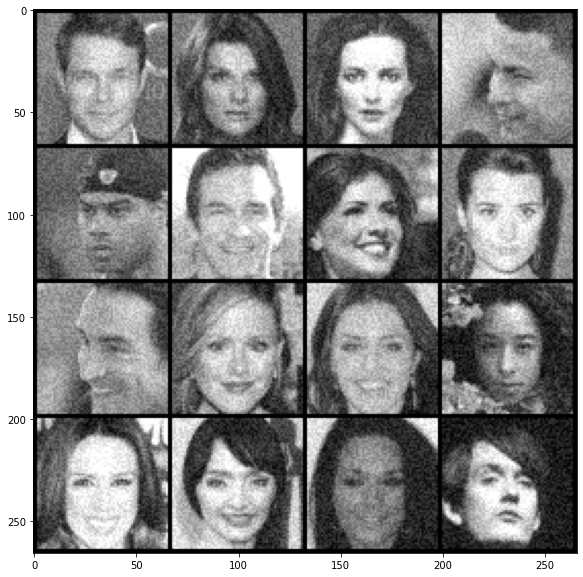

In [534]:
#!g1.1
# print some images
samples = torch.stack([train_dataset[i][0] for i in range(32, 48)], dim=0) + torch.rand_like(samples) * 0.2

plt.figure(figsize=(10, 10))
plt.imshow(make_grid(samples, nrow=4).permute(1, 2, 0))
plt.show()

# Generative adversarial nets 101

<img src="https://raw.githubusercontent.com/torch/torch.github.io/master/blog/_posts/images/model.png" width=320px height=240px>

Deep learning is simple, isn't it? 
* build some network that generates a face (small image)
* make up a __measure__ of __how good this face is__
* optimize with gradient descent :)


The only problem is: how can we engineers tell well-generated faces from bad? And i bet you we won't ask a designer for help. 

__If we can't tell good faces from bad, we delegate it to yet another neural network!__

That makes the two of them:
* __G__enerator - takes random noize for inspiration and tries to generate a face sample. 
  * Let's call him __G__(z), where z is a gaussian noize.
* __D__iscriminator - takes a face sample and tries to tell if it's great or fake. 
  * Predicts the probability of input image being a __real face__
  * Let's call him __D__(x), x being an image.
  * __D(x)__ is a predition for real image and __D(G(z))__ is prediction for the face made by generator.

Before we dive into training them, let's construct the two networks.

In [535]:
#!g1.1
def sample_noise_batch(batch_size):
    noise = torch.randn(batch_size, 100, 1, 1)
    return noise.to(device)

class Reshape(nn.Module):
    def __init__(self, shape):
        nn.Module.__init__(self)
        self.shape = shape

    def forward(self,input):
        return input.view(self.shape)

In [536]:
#!g1.1
class Generator(nn.Module):
    def __init__(self):
        super().__init__()

        self.sequential_1 = nn.Sequential(
            nn.ConvTranspose2d(100, 1024, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(1024),
            nn.ELU(),
        )

        self.sequential_2 = nn.Sequential(
            nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ELU(),
        )

        self.sequential_3 = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ELU(),
        )

        self.sequential_4 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ELU(),
        )

        self.sequential_5 = nn.Sequential(
            nn.ConvTranspose2d(128, 1, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        x = self.sequential_1(input)
        x = x + torch.rand_like(x) * 0.1
        
        x = self.sequential_2(x)
        x = x + torch.rand_like(x) * 0.1
        
        x = self.sequential_3(x)
        x = x + torch.rand_like(x) * 0.1
        
        x = self.sequential_4(x)
        x = x + torch.rand_like(x) * 0.1
        
        x = self.sequential_5(x)
        
        return x

In [537]:
#!g1.1
generator = Generator().to(device)

generated_data = generator(sample_noise_batch(5))
assert tuple(generated_data.shape)[1:] == IMG_SHAPE, "generator must output an image of shape %s, but instead it produces %s"%(IMG_SHAPE, tuple(generated_data.shape)[1:])

### Discriminator
* Discriminator is your usual convolutional network with interlooping convolution and pooling layers
* The network does not include dropout/batchnorm to avoid learning complications.
* We also regularize the pre-output layer to prevent discriminator from being too certain.

In [538]:
#!g1.1
def sample_data_batch(batch_size):
    idxs = np.random.choice(np.arange(len(train_dataset)), size=batch_size)
    batch = torch.stack([train_dataset[idx][0] for idx in idxs], dim=0)
    return batch.to(device)

# a special module that converts [batch, channel, w, h] to [batch, units]
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.shape[0], -1)

In [539]:
#!g1.1
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.sequential = nn.Sequential(
            nn.Conv2d(1, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(512, 1024, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(1024, 1, kernel_size=4, stride=1, padding=0, bias=False),
        )
        
        self.flatten = Flatten()

    def forward(self, input):
        return self.flatten(self.sequential(input))

In [540]:
#!g1.1
discriminator = Discriminator().to(device)
discriminator(sample_data_batch(4)).shape

torch.Size([4, 1])

In [541]:
#!g1.1
def weights_init(layer):
    if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.ConvTranspose2d):
        torch.nn.init.normal_(layer.weight, 0.0, 0.02)
    if isinstance(layer, nn.BatchNorm2d):
        torch.nn.init.normal_(layer.weight, 1.0, 0.02)
        torch.nn.init.constant_(layer.bias, 0)

# Training

We train the two networks concurrently:
* Train __discriminator__ to better distinguish real data from __current__ generator
* Train __generator__ to make discriminator think generator is real
* Since discriminator is a differentiable neural network, we train both with gradient descent.

Training is done iteratively until discriminator is no longer able to find the difference (or until you run out of patience).


### Tricks:
* Regularize discriminator output weights to prevent explosion
* Train generator with __adam__ to speed up training. Discriminator trains with SGD to avoid problems with momentum.
* More: https://github.com/soumith/ganhacks


In [542]:
#!g1.1
def generator_loss(noise):
    """
    1. generate data given noise
    2. compute log P(real | gen noise)
    3. return generator loss (should be scalar)
    """
    generated_data = generator(sample_noise_batch(5))
    
    disc_on_generated_data = discriminator(generated_data)
    
    logp_gen_is_real = F.logsigmoid(disc_on_generated_data)
    
    loss = -torch.mean(logp_gen_is_real)
    
    return loss

In [543]:
#!g1.1
loss = generator_loss(sample_noise_batch(32))

print(loss)

assert len(loss.shape) == 0, "Loss must be scalar"

tensor(0.7782, device='cuda:0', grad_fn=<NegBackward0>)


In [544]:
#!g1.1
def discriminator_loss(real_data, generated_data):
    """
    1. compute discriminator's output on real & generated data
    2. compute log-probabilities of real data being real, generated data being fake
    3. return discriminator loss (scalar)
    """
    disc_on_real_data = discriminator(real_data)
    disc_on_fake_data = discriminator(generated_data)
    
    logp_real_is_real = F.logsigmoid(disc_on_real_data)
    logp_gen_is_fake = F.logsigmoid(-disc_on_fake_data)
    
    loss = -torch.mean(logp_real_is_real) - torch.mean(logp_gen_is_fake)
    return loss

In [545]:
#!g1.1
loss = discriminator_loss(sample_data_batch(32), 
                   generator(sample_noise_batch(32)))

print(loss)

assert len(loss.shape) == 0, "Loss must be scalar"

tensor(1.2505, device='cuda:0', grad_fn=<SubBackward0>)


### Auxilary functions
Here we define a few helper functions that draw current data distributions and sample training batches.

In [546]:
#!g1.1
@torch.no_grad()
def sample_images(nrow, ncol, sharp=False):
    images = generator(sample_noise_batch(batch_size=nrow*ncol))
    images = images.data.cpu().numpy().transpose([0, 2, 3, 1])
    if np.var(images)!=0:
        images = images.clip(0, 1)
    for i in range(nrow*ncol):
        plt.subplot(nrow,ncol,i+1)
        if sharp:
            plt.imshow(images[i], cmap="gray", interpolation="none")
        else:
            plt.imshow(images[i], cmap="gray")
    plt.show()

@torch.no_grad()
def sample_probas(batch_size):
    plt.title('Generated vs real data')
    D_real = torch.sigmoid(discriminator(sample_data_batch(batch_size)))
    generated_data_batch = generator(sample_noise_batch(batch_size))
    D_fake = torch.sigmoid(discriminator(generated_data_batch))
    
    plt.hist(D_real.data.cpu().numpy(),
             label='D(x)', alpha=0.5, range=[0,1])
    plt.hist(D_fake.data.cpu().numpy(),
             label='D(G(z))', alpha=0.5, range=[0,1])
    plt.legend(loc='best')
    plt.show()

### Training
Main loop.
We just train generator and discriminator in a loop and draw results once every N iterations.

In [549]:
#!g1.1
generator = Generator().to(device)
discriminator = Discriminator().to(device)

generator.apply(weights_init)
discriminator.apply(weights_init)

# optimizers
disc_opt = torch.optim.SGD(discriminator.parameters(), lr=5e-3)
gen_opt = torch.optim.Adam(generator.parameters(), lr=1e-4)

In [550]:
#!g1.1
# generator.load_state_dict(torch.load("generator.pth"))
# discriminator.load_state_dict(torch.load("discriminator.pth"))

In [551]:
#!g1.1
# torch.save(generator.state_dict(), "generator.pth")
# torch.save(discriminator.state_dict(), "discriminator.pth")

epoch: 9
generator loss for 100 iterations: 6.71577
discriminator loss for 100 iterations: 0.06995


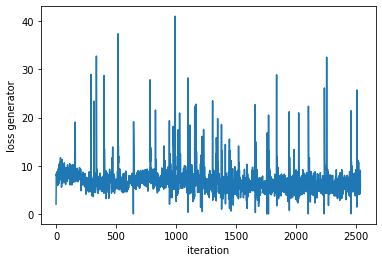

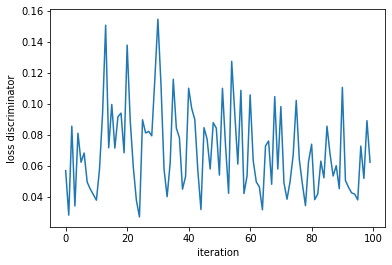

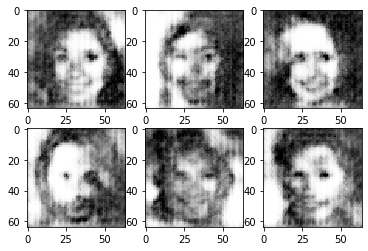

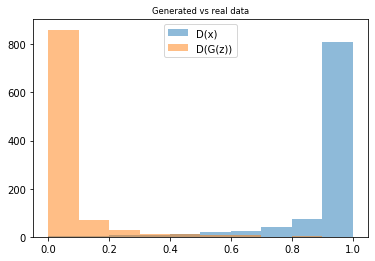

In [552]:
#!g1.1
from IPython import display
from tqdm.auto import tqdm


batch_size = 128
loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

losses_g = []
losses_d = []

for epoch in range(10):
    for iteration, (batch, _) in tqdm(enumerate(loader)):

        generator.train()
        discriminator.train()

        # Train discriminator
        disc_opt.zero_grad()

        real_data = batch.to(device) + torch.rand_like(batch).to(device) * 0.2
        fake_data = generator(sample_noise_batch(batch_size))
        loss_d = discriminator_loss(real_data, fake_data)

        losses_d.append(loss_d.item())

        loss_d.backward()
        disc_opt.step()


        # Train generator
        if iteration % 5 == 0:
            gen_opt.zero_grad()

            noise = sample_noise_batch(batch_size)
            loss_g = generator_loss(noise)

            losses_g.append(loss_g.item())
            
            loss_g.backward()
            gen_opt.step()

        if iteration % 100 == 0:
            torch.save(generator.state_dict(), "generator.pth")
            torch.save(discriminator.state_dict(), "discriminator.pth")            
            display.clear_output(wait=True)
            
            print(f'epoch: {epoch}')
            print(f'generator loss for 100 iterations: {round(np.mean(losses_g[-100:]), 5)}')
            print(f'discriminator loss for 100 iterations: {round(np.mean(losses_d[-100:]), 5)}')
            
            plt.plot(losses_g)
            plt.ylabel('loss generator')
            plt.xlabel('iteration')
            plt.show()
        
            plt.plot(losses_d[-100:])
            plt.ylabel('loss discriminator')
            plt.xlabel('iteration')
            plt.show()
        
            generator.eval()
            discriminator.eval()
        
            sample_images(2, 3, True)
            sample_probas(1000)

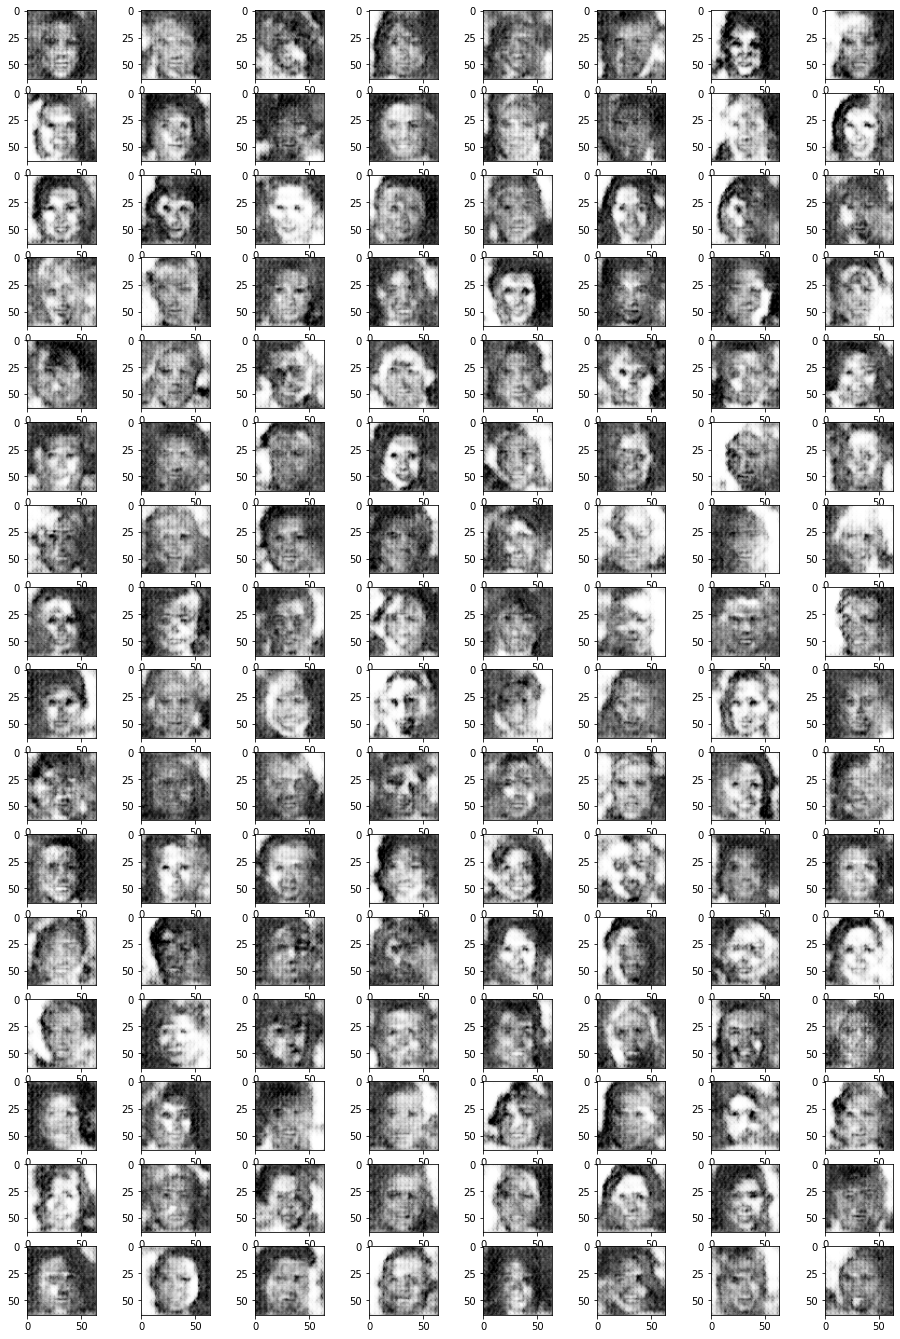

In [553]:
#!g1.1
plt.figure(figsize=[16, 24])
sample_images(16, 8)

# Note: a no-nonsense neural network should be able to produce reasonably good images after 15k iterations
# By "reasonably good" we mean "resembling a car crash victim" or better

In [ ]:
#!g1.1


In [ ]:
#!g1.1
